In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
import numpy as np
from SRM.network import SuperResolution
from torchmetrics.functional.image import peak_signal_noise_ratio
sns.set_style("darkgrid")
sns.set_context("talk")

In [2]:
torch.manual_seed(777)

download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Dataset airplanes already exists, skipping download.


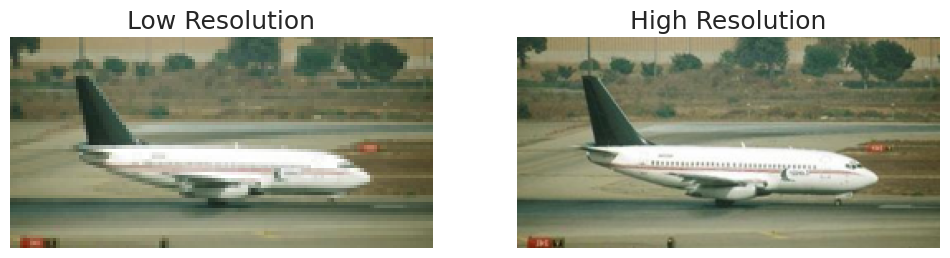

In [3]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(low_res[0].permute(1, 2, 0))
ax[0].set_title("Low Resolution")
ax[0].axis('off')

ax[1].imshow(high_res[0].permute(1, 2, 0))
ax[1].set_title("High Resolution")
ax[1].axis('off')

plt.show()

In [4]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
_ , _, test = split_dataset(dataset,sizes)

test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

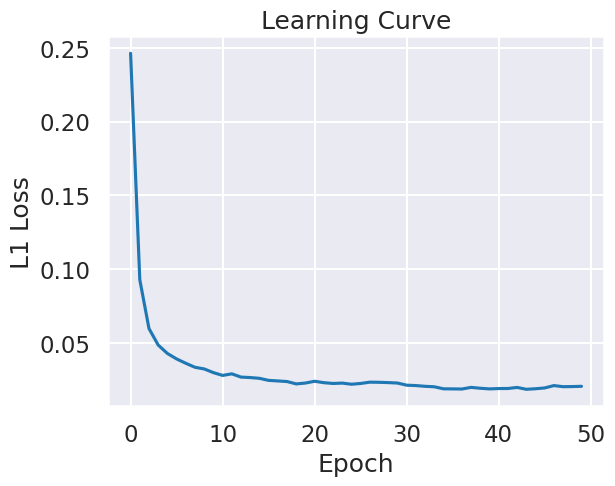

In [5]:
loss_filename = 'training_logs/202408051714_L1.csv'
losses = genfromtxt(loss_filename, delimiter=',')
sns.lineplot(x=np.arange(len(losses)), y=losses)
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Learning Curve')
plt.show()

Test L1: 0.0121399843133986, PSNR 32.921817779541016 db


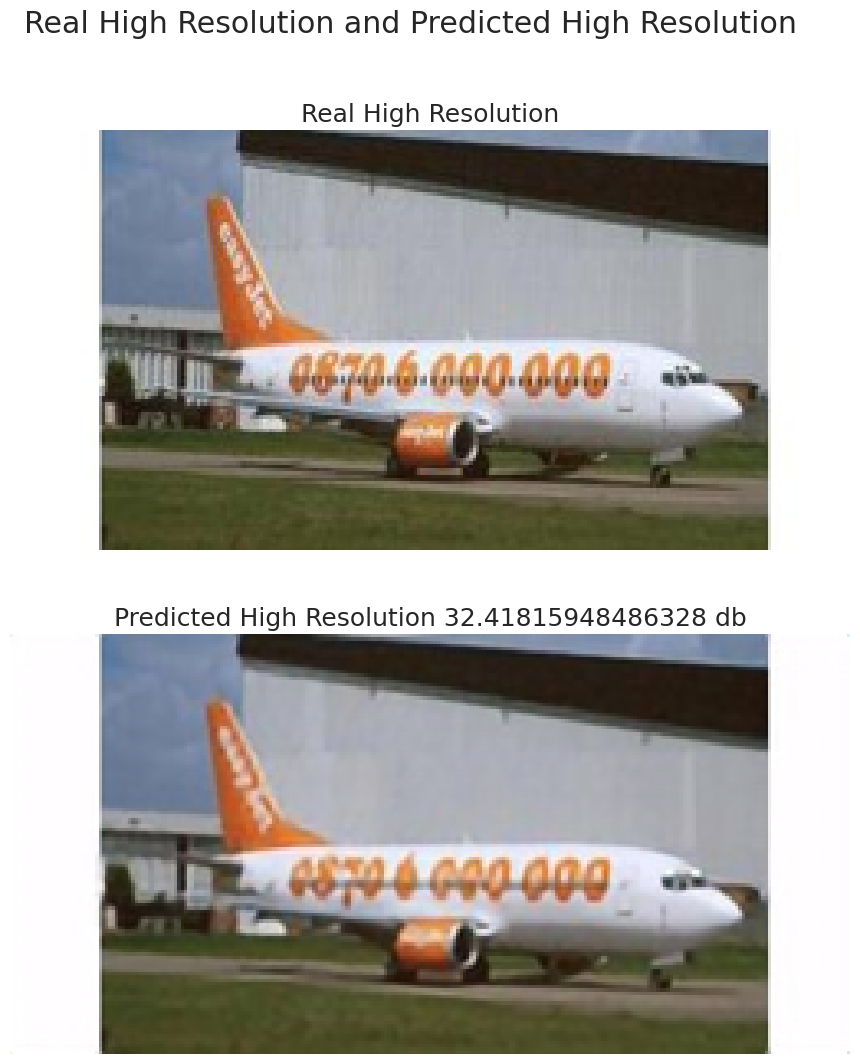

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_filename = "checkpoint/SR_c64_rb8_e150_202408051740.pth"
test_SRN = SuperResolution(64,8)
checkpoint_path = model_filename
test_SRN.load_state_dict(torch.load(checkpoint_path))

loss, psnr = test_SRN.test(nn.L1Loss(), test_dataloader ,device)
print(f"Test L1: {loss}, PSNR {psnr} db")

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)
high_res_test = high_res_test.to(device)

with torch.no_grad():
    predicted_high_res = test_SRN(low_res_test)
    
test_psnr = peak_signal_noise_ratio(predicted_high_res, high_res_test)    
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()
_, ax = plt.subplots(2, figsize=(16, 12)) 
plt.suptitle('Real High Resolution and Predicted High Resolution')

ax[0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0].set_title("Real High Resolution")
ax[0].axis('off') 

ax[1].imshow(predicted_image)
ax[1].set_title(f"Predicted High Resolution {test_psnr} db")
ax[1].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/prediction_comparison.jpg")
plt.show()